# (1) 데이터 다듬기
작업 디렉토리를 설정


```
$ mkdir -p ~/aiffel/lyricist/data
$ mkdir -p ~/aiffel/lyricist/models
```

텐서플로우(TensorFlow)가 제공하는 셰익스피어의 연극 대본 다운로드.


```
$ wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
$ mv shakespeare.txt ~/aiffel/lyricist/data
```

In [1]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf    # 대망의 텐서플로우!
import os

# 파일을 읽기모드로 열어 봅니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()   # 텍스트를 라인 단위로 끊어서 list 형태로 읽어옵니다.

print(raw_corpus[:9])    # 앞에서부터 10라인만 화면에 출력해 볼까요?

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


`:` 를 기준으로 문장 제외, 공백도 제외

In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


텍스트 분류 모델에서 __토큰화(Tokenize)__라는 과정이 있다. 문장을 쪼개서 단어 사전을 만드는 개념이다.<br>
가장 심플한 방법은 띄어쓰기를 기준으로 나누는 방법이다. 그러나 이러한 방법은 약간의 문제가 있다.

1. Hi, my name is John. *("Hi," "my", …, "john." 으로 분리됨) - 문장부호
2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자
3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자

"1." 을 막기 위해 __문장 부호 양쪽에 공백을 추가__ 하고, "2." 를 막기 위해 __모든 문자들을 소문자로 변환__하고. "3."을 막기 위해 __특수문자들은 모두 제거__하여 해결할 수 있다.

이런 전처리를 위해 정규표현식(Regex)을 이용한 필터링이 유용하게 사용된다.

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>


구축해야 할 데이터셋은 아래와 같아야 한다.

```
언어 모델의 입력 문장 :  <start> 나는 밥을 먹었다
언어 모델의 출력 문장 : 나는 밥을 먹었다 <end>
```

자연어처리 분야에서 모델의 입력이 되는 문장을 __소스 문장(Source Sentence)__, 정답 역할을 하게 될 모델의 출력 문장을 __타겟 문장(Target Sentence)__라고 부른다. 각각 X_train, y_train 에 해당한다.

즉, 위에서 만든 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 `<end>`를 없애면 소스 문장, 첫 단어 `<start>`를 없애면 타겟 문장이 되는 것이다.

In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 아래에서 활용하게 될 `tf.keras.preprocessing.text.Tokenizer` 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해준다. 이 과정을 __벡터화(vectorize)__ 라 하며, 숫자로 변환된 데이터를 __텐서(tensor)__ 라고 칭한다. 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리된다는 것이다.

[Tensor란 무엇인가](https://rekt77.tistory.com/102)

In [6]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f40138b1d90>


생성된 텐서 데이터를 3번째 행, 10번째 열까지 출력

In [7]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


단어사전 확인

In [8]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


사전에는 없지만, 텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워넣은 것이다.

In [9]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


corpus 내의 첫번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았다. 소스는 2(`<start>`)에서 시작해서 3(`<end>`)으로 끝난 후 0(`<pad>`)로 채워져 있다. 반면에 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한칸 시프트한 형태를 가지고 있다.

이미 데이터셋을 텐서 형태로 생성해 두었으므로, `tf.data.Dataset.from_tensor_slices()` 메소드를 이용해 `tf.data.Dataset`객체를 생성보겠다.

In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

데이터셋 생성 과정
* 정규표현식을 이용한 corpus 생성
* `tf.keras.preprocessing.text.Tokenizer`를 이용해 corpus를 텐서로 변환
* `tf.data.Dataset.from_tensor_slices()`를 이용해 corpus 텐서를 `tf.data.Dataset`객체로 변환

이 모든 과정을 텐서플로우에서의 __데이터 전처리__ 라 칭한다.

# (2) 인공지능 학습시키기
모델의 구조도
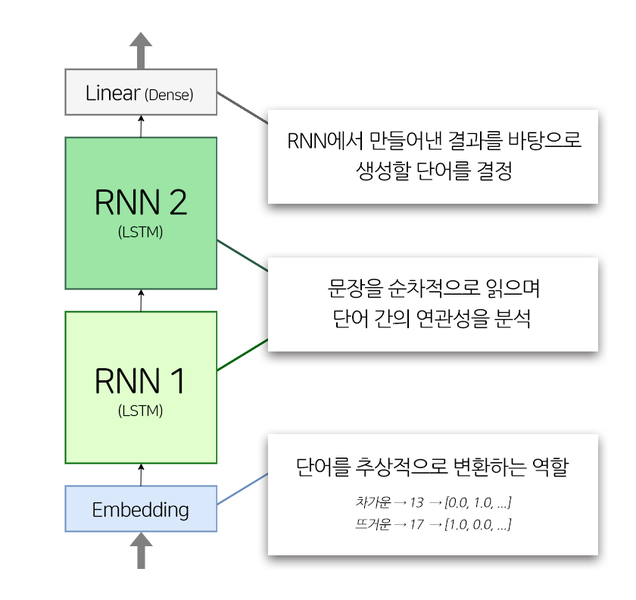

모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것이다. 위 그림에서 설명한 것처럼 모델에는 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성된다.

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

위 코드에서 `embedding_size` 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기이다. 만약 그 크기가 2라면 예를 들어
* 차갑다: [0.0, 1.0]
* 뜨겁다: [1.0, 0.0]
* 미지근하다: [0.5, 0.5]

요런식으로 구분할 수 있다.

값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 __오히려 혼란만을 야기__할 수 있다.<br>
LSTM 레이어의 hidden state 의 차원수인 `hidden_size` 도 같은 개념이다.

In [12]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-1.86524630e-04, -9.23087573e-05, -4.21900550e-05, ...,
          2.66193703e-04, -2.14425425e-04,  2.81080633e-04],
        [-2.88872223e-04, -3.09472933e-04, -1.79014587e-05, ...,
          3.52602015e-04, -4.72354732e-04,  4.43382654e-04],
        [-6.83938270e-04, -3.76970042e-04,  8.66845294e-05, ...,
          8.19710898e-04, -6.22885767e-04,  7.66251818e-04],
        ...,
        [-1.74506230e-03, -4.47066443e-04, -1.35725946e-03, ...,
          2.07451731e-03, -2.67890352e-03,  1.89307588e-03],
        [-2.11501704e-03, -7.07514235e-04, -1.71606313e-03, ...,
          2.19977484e-03, -3.07550118e-03,  2.72542797e-03],
        [-2.45350902e-03, -9.77066113e-04, -2.01623607e-03, ...,
          2.29292526e-03, -3.44800157e-03,  3.49156791e-03]],

       [[-1.86524630e-04, -9.23087573e-05, -4.21900550e-05, ...,
          2.66193703e-04, -2.14425425e-04,  2.81080633e-04],
        [-2.07824734e-04, -4.98488953e-04, -1.

모델의 최종 출력 텐서 shape이 `shape=(256, 20, 7001)`이다. 7001은 Dense 레이어의 출력 차원수이다. 7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링하기 때문이다.<br>
256은 배치 사이즈이다. `dataset.take(1)`를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것이다.<br>
20은 데이터셋의 max_len을 나타낸다.

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


모델을 학습해보자.

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 26s 277ms/step - loss: 3.4911
Epoch 2/30
93/93 [==============================] - 25s 269ms/step - loss: 2.8075
Epoch 3/30
93/93 [==============================] - 25s 270ms/step - loss: 2.7143
Epoch 4/30
93/93 [==============================] - 25s 271ms/step - loss: 2.6158
Epoch 5/30
93/93 [==============================] - 25s 270ms/step - loss: 2.5482
Epoch 6/30
93/93 [==============================] - 25s 271ms/step - loss: 2.4963
Epoch 7/30
93/93 [==============================] - 25s 273ms/step - loss: 2.4408
Epoch 8/30
93/93 [==============================] - 26s 278ms/step - loss: 2.3915
Epoch 9/30
93/93 [==============================] - 25s 274ms/step - loss: 2.3446
Epoch 10/30
93/93 [==============================] - 25s 274ms/step - loss: 2.3021
Epoch 11/30
93/93 [==============================] - 26s 274ms/step - loss: 2.2609
Epoch 12/30
93/93 [==============================] - 26s 275ms/step - loss: 2.2178
Epoch 13/30
9

# (3) 잘 만들어졌는지 평가하기
작문 모델을 평가하는 가장 확실한 방법은 작문을 시켜보고 직접 평가하는 것이다. `generate_text` 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 한다.

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

문장 생성 함수 실행하기

In [18]:
generate_text(model, tokenizer, init_sentence="<start> she")

'<start> she is not lolling on a lewd day bed , <end> '